#**QAOA - Quantum Approximate Optimzation Algorithm**
## Portfolio Optimization - A Finance Use Case



####**Author / Date**

**[qubit-lab.ch](http://qubit-lab.ch)** / July 2025  

####**Versions used**
- Python 3.10.9
- Qiskit 1.1.0 (see first cell)

####Find an explaining video and further resources on **[qubit-lab.ch](http://qubit-lab.ch)**


#**Installing Qiskit in a previous, running version**

In [1]:
# Install Qiskit 1.1.0 and its compatible dependencies.
# We are specifically targeting versions that work well together.
!pip install qiskit==1.1.0 qiskit-algorithms==0.3.1 qiskit-aer==0.17.0 qiskit-optimization==0.6.1 qiskit-aer --quiet

# Verify the installed Qiskit version and critical imports for Qiskit 1.x
print("\nVerifying Qiskit 1.x installation...")
try:
    import qiskit
    print(f"SUCCESS: Qiskit version after install: {qiskit.__version__}")
    # Test the specific import that caused issues (now in 1.x style)
    from qiskit_algorithms.minimum_eigensolvers import QAOA
    from qiskit_algorithms.optimizers import COBYLA
    print("SUCCESS: `qiskit_algorithms` imports are working as expected for Qiskit 1.x.")
except Exception as e:
    print(f"ERROR during verification: {e}")
    print("This indicates a highly persistent environment issue in Colab.")
print("\n--- Installation commands finished ---")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.1 MB/s eta 0:00:00

Verifying Qiskit 1.x installation...
SUCCESS: Qiskit version after install: 1.1.0
SUCCESS: `qiskit_algorithms

#**Loading Financia Data**

/tmp/ipython-input-2-1475706657.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, start='2024-07-01', end='2025-06-30', interval='1d')
[*********************100%***********************]  10 of 10 completed


   Asset       Price  Return (%)  Volatility (%)
0   AAPL  201.080002   -2.055101       32.150172
1   AMZN  223.300003   18.603630       34.665263
2  GOOGL  178.529999    3.135188       32.132381
3    JNJ  152.410004    9.133588       19.009786
4    JPM  285.733429   40.332424       28.321918
5   META  733.630005   45.272859       37.359653
6   MSFT  495.940002   12.368911       25.535789
7   NVDA  157.750000   40.958994       57.820682
8      V  348.609985   31.985842       23.179205
9    XOM  109.379997    1.358355       24.168991


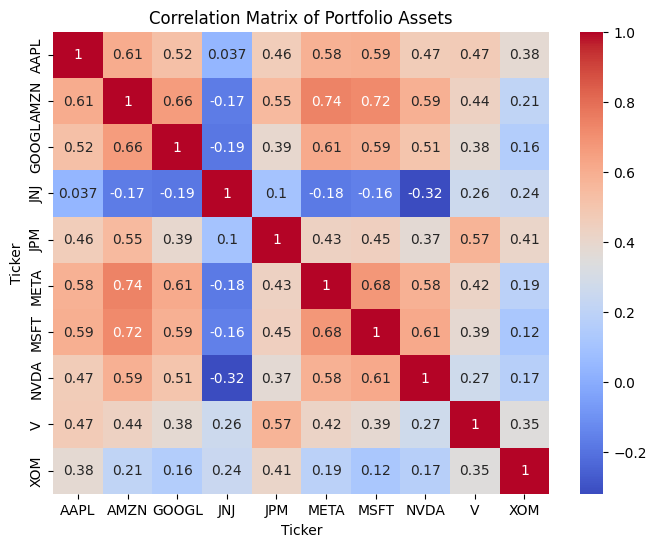

In [2]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from scipy.optimize import minimize
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

num_assets = 10
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'JPM', 'XOM', 'JNJ', 'V']

data = yf.download(assets, start='2024-07-01', end='2025-06-30', interval='1d')

# CASE 1: MultiIndex columns (Open, Close, etc. for each ticker)
if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.levels[0]:
        close = data['Adj Close']
    elif 'Close' in data.columns.levels[0]:
        close = data['Close']
    else:
        raise ValueError(f"Data has multi-level columns, but no 'Adj Close' or 'Close' found:\n{data.columns}")
else:
    # CASE 2: Columns are tickers directly (already just prices)
    close = data

close = close.dropna()
clean_assets = close.columns.tolist()

prices = close.iloc[-1].values
returns = close.pct_change().mean() * 252
volatility = close.pct_change().std() * np.sqrt(252)

prices = np.asarray(prices)
returns = np.asarray(returns)
volatility = np.asarray(volatility)

# Always make sure all arrays are the same length
assert len(prices) == len(clean_assets) == len(returns) == len(volatility)

asset_df = pd.DataFrame({
    'Asset': clean_assets,
    'Price': prices,
    'Return (%)': returns * 100,
    'Volatility (%)': volatility * 100
})

print(asset_df)

# --- Step 2: Covariance matrix (annualized covariance of daily returns) ---
returns_daily = close.pct_change().dropna()
covariance = returns_daily.cov().values * 252  # annualized covariance

corr = returns_daily.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=clean_assets, yticklabels=clean_assets)
plt.title("Correlation Matrix of Portfolio Assets")
plt.show()

#**QAOA Implementation and Brute Force as Benchmark**

Starting global QAOA parameter optimization for p = 7...
Starting Differential Evolution for p = 7           with 14 parameters...
differential_evolution step 1: f(x)= 0.9234665027270341
differential_evolution step 2: f(x)= 0.9234665027270341
differential_evolution step 3: f(x)= 0.9234665027270341
differential_evolution step 4: f(x)= 0.9234665027270341
differential_evolution step 5: f(x)= 0.9234665027270341
differential_evolution step 6: f(x)= 0.9234665027270341
differential_evolution step 7: f(x)= 0.9234665027270341
differential_evolution step 8: f(x)= 0.9234665027270341
differential_evolution step 9: f(x)= 0.9234665027270341
differential_evolution step 10: f(x)= 0.9234665027270341
differential_evolution step 11: f(x)= 0.9234665027270341
differential_evolution step 12: f(x)= 0.9234665027270341
differential_evolution step 13: f(x)= 0.9234665027270341
differential_evolution step 14: f(x)= 0.8967265366970825
differential_evolution step 15: f(x)= 0.8967265366970825
differential_evolution 

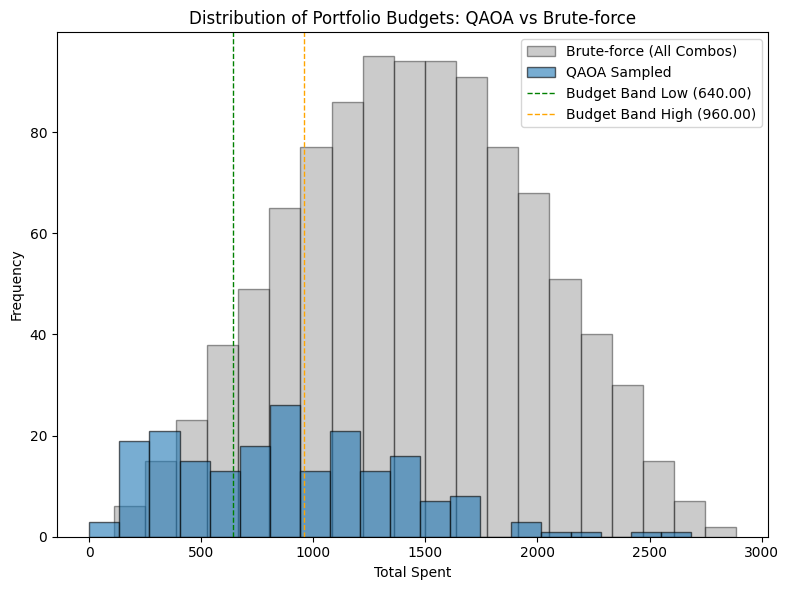

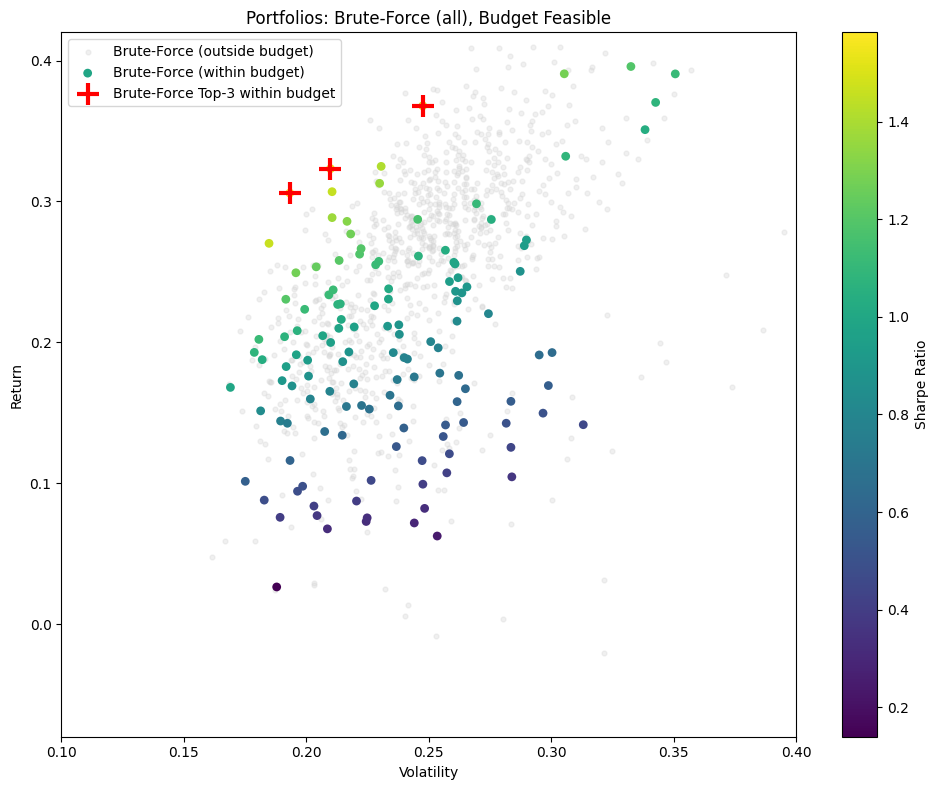

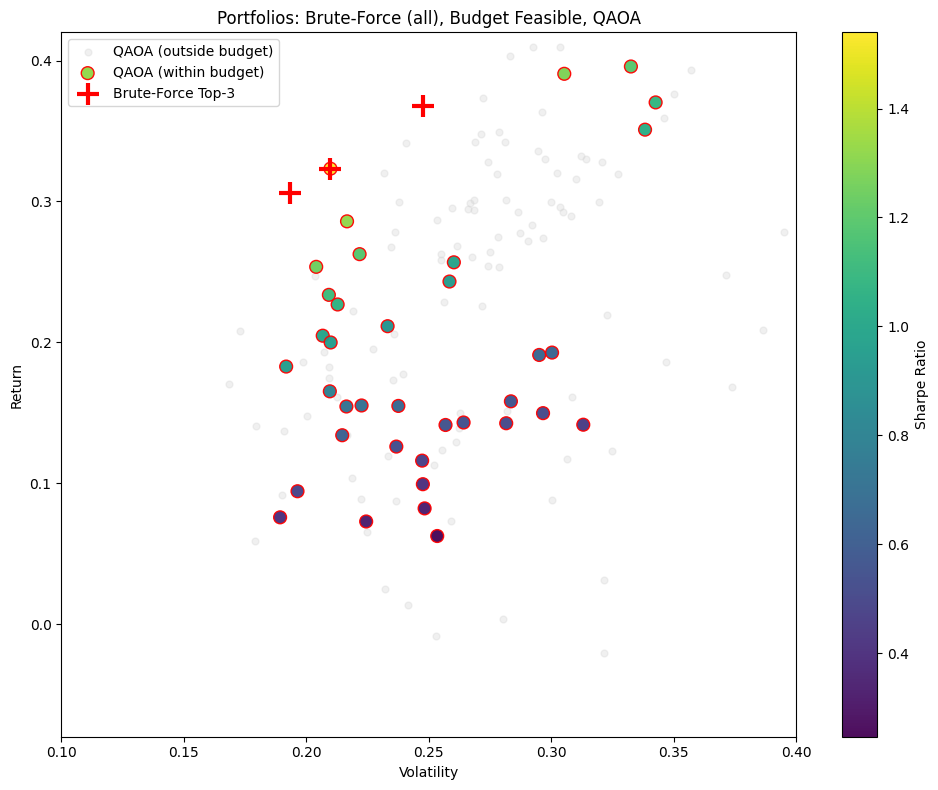

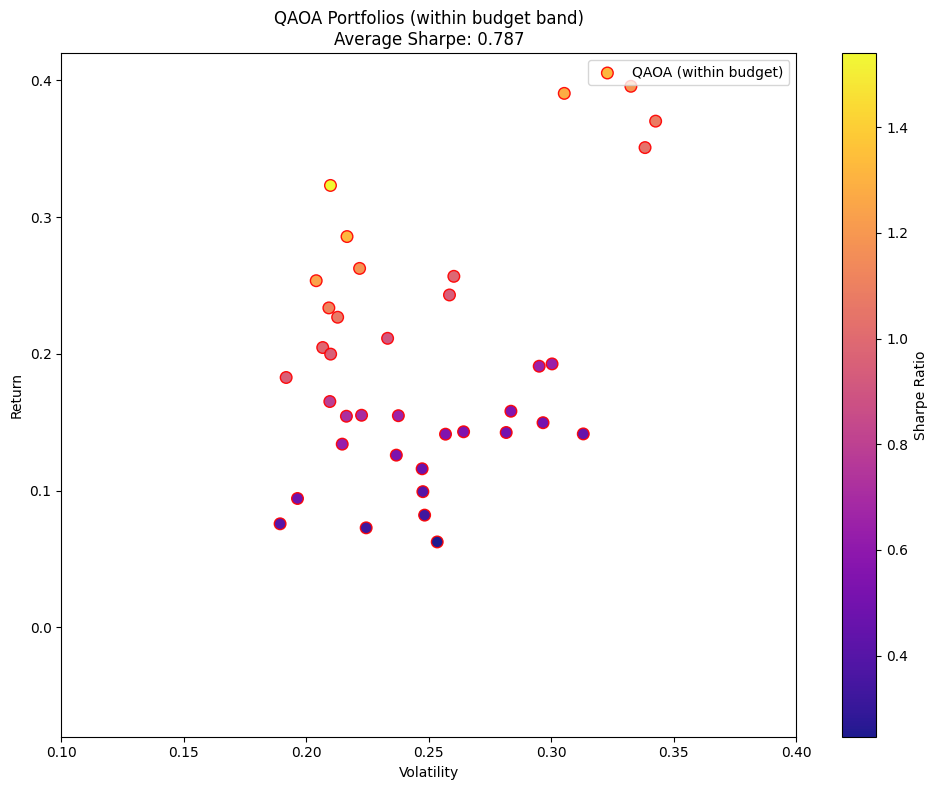

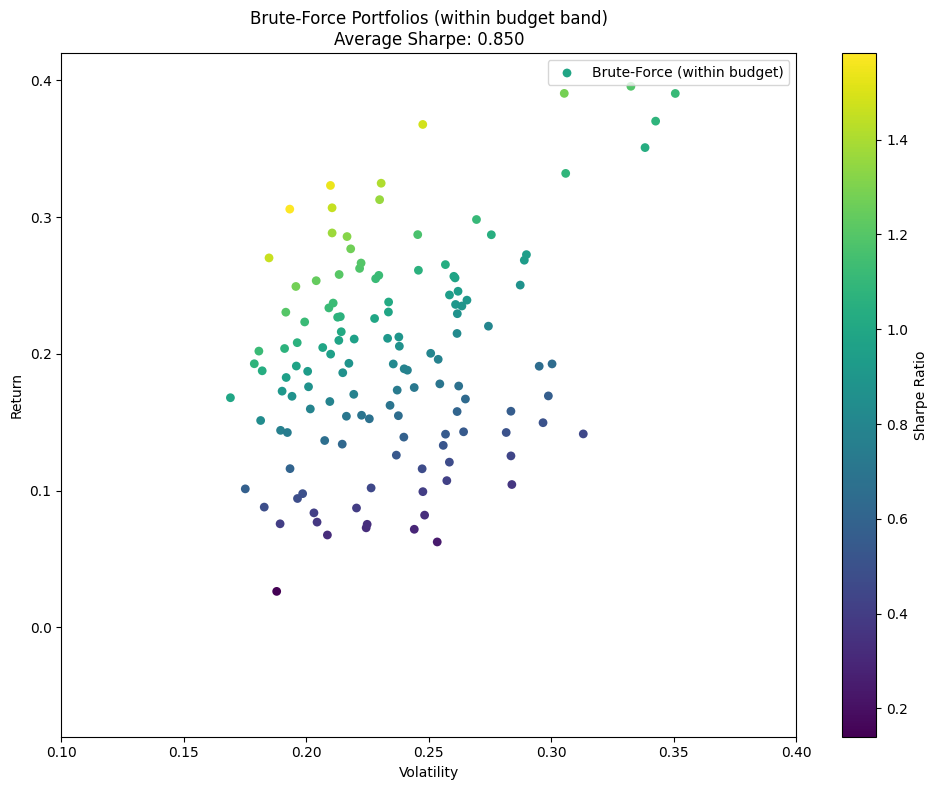

In [3]:
import numpy as np
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
from itertools import product

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(0)

# --- Parameters ---
budget         = 800           # Budget in USD
shots          = 200           # Shots per QAOA run
target_p_value = 7             # QAOA depth (number of layers)
alpha          = 5             # Budget penalty
return_weight  = 5             # Relative weight of returns in QUBO
risk_weight    = 8             # Relative weight of risk in QUBO (=lambda)
optimizer_iterations = 50      # Number of iterations to optimize gamma/beta

# Define budget acceptance band (±20%)
band_low  = 0.80 * budget
band_high = 1.20 * budget

# --- Helper: QUBO and Ising energy evaluation ---
def qubo_value(bits, Q, c):
    """Evaluate QUBO value for given bitstring."""
    x = np.array(bits)
    return float(x @ Q @ x + c @ x)

def ising_value(bits, h, J):
    """Evaluate Ising energy for given bitstring."""
    z = 1 - 2 * np.array(bits)  # Binary-to-spin conversion
    e = np.sum(h * z)
    for i in range(len(bits)):
        for j in range(i+1, len(bits)):
            e += J[i, j] * z[i] * z[j]
    return float(e)

# --- Piecewise budget penalty ---
def budget_piecewise_penalty(cost):
    if cost < band_low:
        return alpha * (band_low - cost) ** 2 / budget**2
    elif cost > band_high:
        return alpha * (cost - band_high) ** 2 / budget**2
    return 0.0

# --- Step 1: QUBO Setup (cost, constraints, scaling) ---
Q = np.zeros((num_assets, num_assets))                                 # Quadratic term (risk, budget, asset count)
c = -return_weight * returns.copy() * prices / budget                  # Linear term (returns)

# Add risk to QUBO
for i in range(num_assets):
    for j in range(num_assets):
        Q[i, j] += risk_weight * covariance[i, j] * prices[i] * prices[j] / budget**2

# Add budget penalty (quadratic and linear)
for i in range(num_assets):
    c[i] += -2 * alpha * prices[i] / budget
    Q[i, i] += alpha * prices[i] * prices[i] / budget**2
for i in range(num_assets):
    for j in range(i + 1, num_assets):
        Q[i, j] += 2 * alpha * prices[i] * prices[j] / budget**2
        Q[j, i] = Q[i, j]


# Normalization
max_q_abs = np.max(np.abs(Q))
max_c_abs = np.max(np.abs(c))
scale_factor = max(max_q_abs, max_c_abs) / 0.1
Q /= scale_factor
c /= scale_factor

# --- Step 2: Convert QUBO to Ising Hamiltonian (needed for QAOA cost) ---
h = np.zeros(num_assets)
J = np.zeros((num_assets, num_assets))
for i in range(num_assets):
    h[i] = Q[i, i] / 4 + c[i] / 2 + np.sum(Q[i, :]) / 4 - Q[i, i] / 4
    for j in range(i + 1, num_assets):
        J[i, j] = Q[i, j] / 4

# --- Step 3+4: QAOA Circuit construction ---
def qaoa_circuit(gammas, betas, p_current, num_assets, h, J):
    qc = QuantumCircuit(num_assets)
    for q in range(num_assets):
        qc.h(q)
    for layer in range(p_current):
        gamma = gammas[layer]
        for i in range(num_assets):
            qc.rz(-2 * gamma * h[i], i)
        for i in range(num_assets):
            for j in range(i + 1, num_assets):
                if J[i, j] != 0:
                    qc.rzz(-2 * gamma * J[i, j], i, j)
        beta = betas[layer]
        for i in range(num_assets):
            qc.rx(2 * beta, i)
    qc.measure_all()
    return qc

# --- QAOA objective function (for optimizer) ---
def get_expectation(params, p_current, num_assets, h, J, shots):
    # Evaluate QAOA expectation value with current parameters
    gammas = params[:p_current]
    betas = params[p_current:]
    qc = qaoa_circuit(gammas, betas, p_current, num_assets, h, J)
    from qiskit_aer.primitives import Sampler
    sampler = Sampler()
    result = sampler.run(qc, shots=shots).result()
    probs = result.quasi_dists[0]
    energy = 0
    for bitstr_int, prob in probs.items():
        bitstr = np.array([int(b) for b in format(bitstr_int, f'0{num_assets}b')])
        z = 1 - 2 * bitstr
        e = np.sum(h * z)
        for i in range(num_assets):
            for j in range(i + 1, num_assets):
                e += J[i, j] * z[i] * z[j]
        total_cost = np.sum(prices * bitstr)
        e += budget_piecewise_penalty(total_cost)  # Add piecewise penalty to energy
        energy += prob * e
    return energy

def qaoa_objective_wrapper(params, num_assets, h_coeffs, J_coeffs,
                           p_val, shots_count):
    return get_expectation(params, p_val, num_assets, h_coeffs,
                           J_coeffs, shots_count)

# --- Step 5: Optimize QAOA parameters globally ---
def optimize_qaoa_global(num_assets, h, J, p, shots):
    gamma_bounds = [(0, 2 * np.pi)] * p
    beta_bounds = [(0, np.pi)] * p
    bounds = gamma_bounds + beta_bounds
    print(f"Starting Differential Evolution for p = {p} \
          with {2*p} parameters...")
    if optimizer_iterations > 0:
        result = differential_evolution(
          func=qaoa_objective_wrapper,
          bounds=bounds,
          args=(num_assets, h, J, p, shots),
          strategy='best1bin',
          maxiter= optimizer_iterations,
          popsize= 2 * target_p_value + 1,
          tol=0.01,
          seed=None,
          disp=True
        )
        optimal_params = result.x
        optimal_gammas = optimal_params[:p]
        optimal_betas = optimal_params[p:]
        print(f"Optimal energy for p={p}: {result.fun:.4f}")
        print(f"  Gammas: {[f'{g}' for g in optimal_gammas]}")
        print(f"  Betas:  {[f'{b}' for b in optimal_betas]}")
    else:
        optimal_gammas = [2.519737869784621, 2.6140044337560395, 2.524750404614688, 0.9212260443838178, 1.2309396197487656, 0.38508299641177723, 1.5585684814681566]  # Adjusted for p=7
        optimal_betas = [1.0081688201539534, 2.0691986404594402, 1.3055007042441293, 3.0951919624828736, 1.980006486253819, 2.901725708406172, 2.047837976558239]

    return optimal_gammas, optimal_betas

# --- Optimize QAOA parameters ---
print(f"Starting global QAOA parameter optimization for p = {target_p_value}...")
gammas_opt, betas_opt = optimize_qaoa_global(num_assets, h, J, target_p_value, shots)
p = target_p_value

print(f"\n==== Final Optimal Parameters for p={p} ====")
print(f"Optimal gammas: {gammas_opt}")
print(f"Optimal betas: {betas_opt}")

# --- Sample from QAOA circuit (Qiskit required) ---
qc_opt = qaoa_circuit(gammas_opt, betas_opt, p, num_assets, h, J)
from qiskit_aer.primitives import Sampler
sampler = Sampler()
result = sampler.run(qc_opt, shots=shots).result()
probs = result.quasi_dists[0]
counts = {format(k, f'0{num_assets}b'): int(v * shots) for k, v in probs.items()}

# --- Evaluate QAOA portfolios ---
def eval_portfolio(bits):
    bits = np.array([int(b) for b in bits])
    sel_prices = prices[bits == 1]
    sel_returns = returns[bits == 1]
    sel_indices = np.where(bits == 1)[0]
    total_cost = np.sum(sel_prices)
    if len(sel_indices) > 0:
        w = sel_prices / np.sum(sel_prices)
        cov_selected = covariance[np.ix_(sel_indices, sel_indices)]
        port_return = np.sum(w * sel_returns)
        port_vol = np.sqrt(w.T @ cov_selected @ w)
        sharpe = port_return / port_vol if port_vol > 0 else 0
        return port_return, port_vol, sharpe, total_cost
    return None

results = []
within_band = 0
below_band = 0
above_band = 0

# Gather results for QAOA samples
for bits, freq in counts.items():
    bits_arr = np.array([int(b) for b in bits])
    total_cost = np.sum(prices[bits_arr == 1])
    if total_cost < band_low:
        below_band += freq
    elif band_low <= total_cost <= band_high:
        within_band += freq
    else:
        above_band += freq
    res = eval_portfolio(bits)
    if res is not None:
        results.append((*res, bits, freq))

# --- Show Top-10 QAOA portfolios, only within budget band ---
if results:
    results_in_band = [r for r in results if band_low <= r[3] <= band_high]

    results_sorted = sorted(results_in_band, key=lambda x: x[2], reverse=True)
    top_n = 10
    print(f"\n==== Top {top_n} measured portfolios (QAOA, by Sharpe, within budget band) ====")
    for idx, (port_return, port_vol, sharpe, cost, bits, freq) in enumerate(results_sorted[:top_n], 1):
        selected_mask = np.array([int(b) for b in bits])
        qval = qubo_value(selected_mask, Q, c)
        ival = ising_value(selected_mask, h, J)
        print(f"\n#{idx}: Sharpe={sharpe:.2f} | Spent={cost:.2f} | Return={port_return*100:.2f}% | Vol={port_vol*100:.2f}%")
        print(f"  QUBO value: {qval:.2f}  Ising energy: {ival:.2f}  Hits: {freq}")
        print(f"  Assets: {np.where(selected_mask == 1)[0]}")
        if np.sum(selected_mask) > 0:
            sel_df = asset_df.iloc[np.where(selected_mask == 1)[0]].copy()
            print(sel_df.to_string(index=False))
        else:
            print("  No assets selected.")

    print(f"\nBudget window: {band_low:.2f} .. {band_high:.2f} USD")
    print(f"  Shots below  window: {below_band}")
    print(f"  Shots within window: {within_band}")
    print(f"  Shots above  window: {above_band}")
    print(f"  Total shots:      {sum(counts.values())}")
else:
    print("No valid portfolios found in measured results.")

# --- Brute-force all feasible portfolios (for reference) ---
print("\n=== Brute-force portfolios within budget ===")

feasible = []
bf_spent_list = []

# Lists for plotting comparison with QAOA
all_bf_vols, all_bf_rets, all_bf_sharpes = [], [], []
in_bf_vols, in_bf_rets, in_bf_sharpes = [], [], []

for bits in product([0, 1], repeat=num_assets):
    bits_arr = np.array(bits)
    total_cost = np.sum(prices[bits_arr == 1])

    if np.sum(bits_arr) == 0:
        continue  # Skip empty portfolios

    # Proper weights of selected assets
    sel_indices = np.where(bits_arr == 1)[0]
    sel_prices = prices[sel_indices]
    sel_returns = returns[sel_indices]
    w = sel_prices / np.sum(sel_prices)

    # Correct volatility calculation using covariance matrix
    cov_selected = covariance[np.ix_(sel_indices, sel_indices)]
    port_vol = np.sqrt(w.T @ cov_selected @ w)
    port_return = np.sum(w * sel_returns)
    sharpe = port_return / port_vol if port_vol > 0 else 0

    # Add to all brute-force lists
    all_bf_vols.append(port_vol)
    all_bf_rets.append(port_return)
    all_bf_sharpes.append(sharpe)

    # Within budget
    if band_low <= total_cost <= band_high:
        feasible.append((port_return, port_vol, sharpe, total_cost, bits))
        in_bf_vols.append(port_vol)
        in_bf_rets.append(port_return)
        in_bf_sharpes.append(sharpe)

    bf_spent_list.append(total_cost)

# Sort feasible portfolios by Sharpe ratio
if feasible:
    feasible_sorted = sorted(feasible, key=lambda x: x[2], reverse=True)
    print("Top 5 brute-force portfolios by Sharpe ratio:")
    for port_return, port_vol, sharpe, cost, bits in feasible_sorted[:5]:
        print(f"Bits={bits}, Spent={cost:.2f}, Return={port_return*100:.2f}%, "
              f"Vol={port_vol*100:.2f}%, Sharpe={sharpe:.2f}")
    print()

    brute_force_list = [(sharpe, bits) for (_, _, sharpe, _, bits) in feasible]
else:
    print("No brute-force portfolios within budget window!")

# Separate QAOA samples into inside and outside budget
qaoa_in_vols, qaoa_in_rets, qaoa_in_sharpes = [], [], []
qaoa_out_vols, qaoa_out_rets, qaoa_out_sharpes = [], [], []

for bits, freq in counts.items():
    res = eval_portfolio(bits)
    if res is not None:
        port_return, port_vol, sharpe, cost = res
        if band_low <= cost <= band_high:
            qaoa_in_vols.append(port_vol)
            qaoa_in_rets.append(port_return)
            qaoa_in_sharpes.append(sharpe)
        else:
            qaoa_out_vols.append(port_vol)
            qaoa_out_rets.append(port_return)
            qaoa_out_sharpes.append(sharpe)

# --- Step 10: Plot results ---

# Plot spending distribution: Brute Force and QAOA

spent_list = []
for bits, freq in counts.items():
    bits_arr = np.array([int(b) for b in bits])
    total_cost = np.sum(prices[bits_arr == 1])
    spent_list += [total_cost] * freq

if spent_list and bf_spent_list: # Only plot if data is available
    plt.figure(figsize=(8, 6))
    plt.hist(bf_spent_list, bins=20, alpha=0.4, label='Brute-force (All Combos)', color='tab:gray', edgecolor='black')
    plt.hist(spent_list, bins=20, alpha=0.6, label='QAOA Sampled', color='tab:blue', edgecolor='black')
    plt.axvline(band_low, color='green', linestyle='dashed', linewidth=1, label=f'Budget Band Low ({band_low:.2f})')
    plt.axvline(band_high, color='orange', linestyle='dashed', linewidth=1, label=f'Budget Band High ({band_high:.2f})')
    plt.xlabel("Total Spent")
    plt.ylabel("Frequency")
    plt.title("Distribution of Portfolio Budgets: QAOA vs Brute-force")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Prepare data for overlays ---
if feasible:
    brute5 = feasible_sorted[:5]
    brute_vols = [x[1] for x in brute5]
    brute_rets = [x[0] for x in brute5]
    brute_sharpes = [x[2] for x in brute5]
else:
    brute_vols, brute_rets, brute_sharpes = [], [], []

# --- Plot Brute Force: all vs within budget ---
plt.figure(figsize=(10,8))

# a) All brute-force portfolios (outside budget: gray, small, faint)
plt.scatter(all_bf_vols, all_bf_rets, c='lightgray', s=12, alpha=0.32, label='Brute-Force (outside budget)', zorder=1)

# b) Brute-force within budget (colored by Sharpe, larger, on top)
if in_bf_vols:
    in_bf = plt.scatter(in_bf_vols, in_bf_rets, c=in_bf_sharpes, cmap='viridis', s=40, label='Brute-Force (within budget)', zorder=2, edgecolor='none')

# c) Top-3 Sharpe within-budget brute-force: big red '+'
if in_bf_vols:
    import numpy as np
    top3_idx = np.argsort(in_bf_sharpes)[-3:][::-1]
    plt.scatter([in_bf_vols[i] for i in top3_idx], [in_bf_rets[i] for i in top3_idx],
                marker='+', s=250, c='red', linewidths=3, label='Brute-Force Top-3 within budget', zorder=5)

plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolios: Brute-Force (all), Budget Feasible')
if in_bf_vols:
    plt.colorbar(in_bf, label='Sharpe Ratio')
plt.legend()
plt.xlim(0.1, 0.40)
plt.ylim(-0.08, 0.42)
plt.tight_layout()
plt.show()


# --- Plot QAOA all vs within budget ---

plt.figure(figsize=(10,8))


# a) QAOA out-of-budget (small, blue edge)
if qaoa_out_vols:
    plt.scatter(qaoa_out_vols, qaoa_out_rets, c='lightgray', s=24, alpha=0.32, label='QAOA (outside budget)', zorder=3)

# b) QAOA within budget (bold, red edge)
if qaoa_in_vols:
    qaoa = plt.scatter(qaoa_in_vols, qaoa_in_rets, c=qaoa_in_sharpes, cmap='viridis',
                       alpha=0.95, label='QAOA (within budget)', edgecolor='red', linewidths=1, s=85, zorder=4)

# c) Top-3 Sharpe within-budget brute-force: big red '+'
if in_bf_vols:
    import numpy as np
    top3_idx = np.argsort(in_bf_sharpes)[-3:][::-1]
    plt.scatter([in_bf_vols[i] for i in top3_idx], [in_bf_rets[i] for i in top3_idx],
                marker='+', s=250, c='red', linewidths=3, label='Brute-Force Top-3', zorder=5)

plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolios: Brute-Force (all), Budget Feasible, QAOA')

# Only add colorbar if qaoa exists
if qaoa_in_vols:
    plt.colorbar(qaoa, label='Sharpe Ratio')

plt.legend()
plt.xlim(0.1, 0.4)
plt.ylim(-0.08, 0.42)
plt.tight_layout()
plt.show()




import numpy as np
import matplotlib.pyplot as plt

# === Compute average Sharpe ratios (within budget band only) ===

# Brute-force: filter to within budget band
avg_sharpe_bf = np.mean(in_bf_sharpes) if in_bf_sharpes else float('nan')

# QAOA: select only portfolios within budget band
qaoa_in_vols, qaoa_in_rets, qaoa_in_sharpes = [], [], []
qaoa_in_freqs = []
for bits, freq in counts.items():
    bits_arr = np.array([int(b) for b in bits])
    total_cost = np.sum(prices[bits_arr == 1])
    if band_low <= total_cost <= band_high:
        res = eval_portfolio(bits)
        if res is not None:
            port_return, port_vol, sharpe, cost = res
            qaoa_in_vols.append(port_vol)
            qaoa_in_rets.append(port_return)
            qaoa_in_sharpes.append(sharpe)
            qaoa_in_freqs.append(freq)
avg_sharpe_qaoa = np.average(qaoa_in_sharpes, weights=qaoa_in_freqs) if qaoa_in_sharpes else float('nan')

# === Plot QAOA portfolios within budget band ===

plt.figure(figsize=(10,8))
if qaoa_in_vols:
    qaoa = plt.scatter(qaoa_in_vols, qaoa_in_rets, c=qaoa_in_sharpes, cmap='plasma',
                       s=70, alpha=0.93, label='QAOA (within budget)', edgecolor='red', linewidths=1, zorder=2)
    plt.colorbar(qaoa, label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title(f'QAOA Portfolios (within budget band)\nAverage Sharpe: {avg_sharpe_qaoa:.3f}')
plt.legend()
plt.xlim(0.1, 0.40)
plt.ylim(-0.08, 0.42)
plt.tight_layout()
plt.show()

# === Plot Brute Force portfolios within budget band ===

plt.figure(figsize=(10,8))
if in_bf_vols:
    in_bf = plt.scatter(in_bf_vols, in_bf_rets, c=in_bf_sharpes, cmap='viridis',
                        s=40, label='Brute-Force (within budget)', edgecolor='none', zorder=1)
    plt.colorbar(in_bf, label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title(f'Brute-Force Portfolios (within budget band)\nAverage Sharpe: {avg_sharpe_bf:.3f}')
plt.legend()
plt.xlim(0.1, 0.40)
plt.ylim(-0.08, 0.42)
plt.tight_layout()
plt.show()

#**QUBO Parameter Tuning Plots**

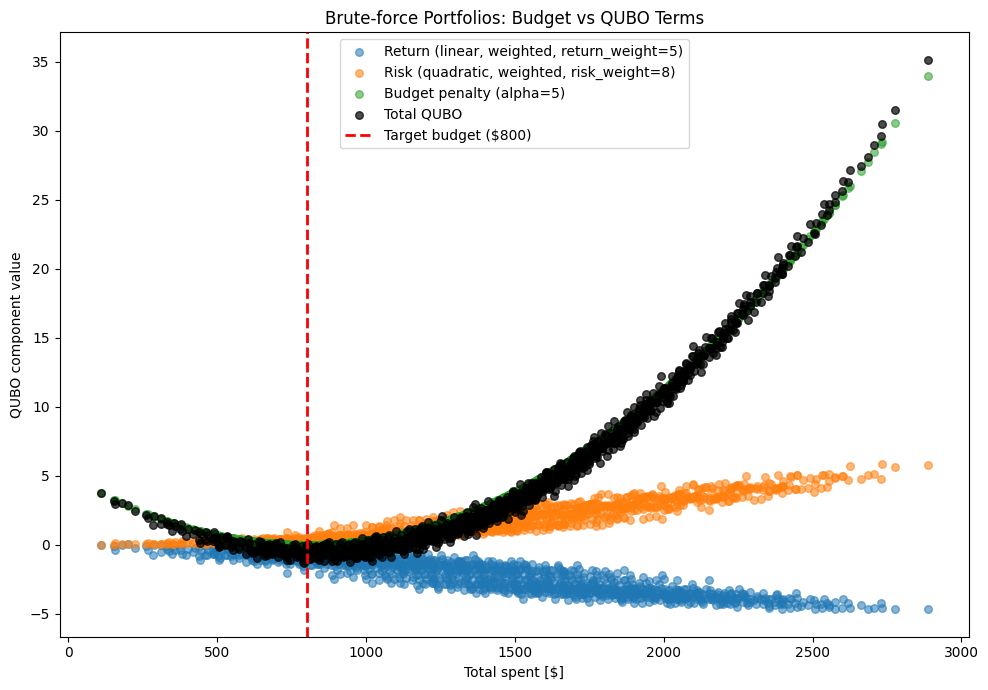

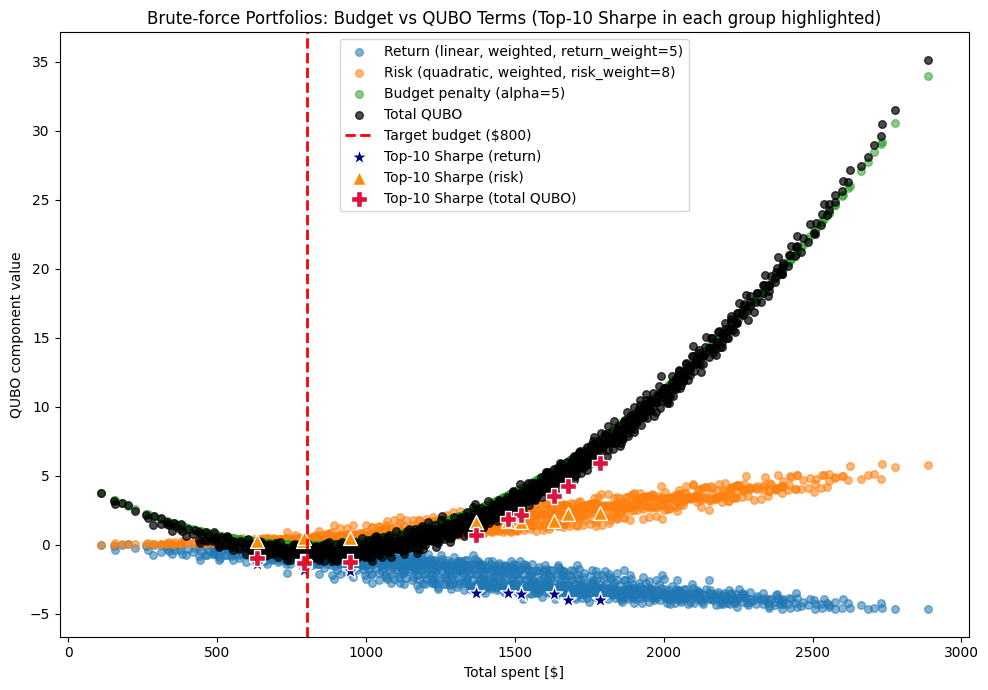

In [4]:

from itertools import product
import matplotlib.pyplot as plt

spent_list = []
return_list = []
risk_list = []
budget_list = []
total_qubo_list = []


for bits in product([0, 1], repeat=num_assets):
    x = np.array(bits)
    if np.sum(x) == 0:
        continue  # skip empty portfolios

    # Total spent
    spent = np.sum(prices * x)
    spent_list.append(spent)

    # Return (linear, with weight/sign)
    return_contrib = np.dot(-return_weight * returns * prices / budget, x)
    return_list.append(return_contrib)

    # Risk (quadratic, with weight)
    risk_contrib = 0.0
    for i in range(num_assets):
        for j in range(num_assets):
            risk_contrib += risk_weight * covariance[i, j] * prices[i] * prices[j] / budget**2 * x[i] * x[j]
    risk_list.append(risk_contrib)

    # Budget penalty (with constant)
    budget_penalty = alpha * ((spent - budget) / budget) ** 2
    budget_list.append(budget_penalty)

    # Total QUBO
    total_qubo = return_contrib + risk_contrib + budget_penalty
    total_qubo_list.append(total_qubo)

plt.figure(figsize=(10,7))

plt.scatter(spent_list, return_list, s=30, color='tab:blue', alpha=0.55,
            label=f'Return (linear, weighted, return_weight={return_weight})')
plt.scatter(spent_list, risk_list, s=30, color='tab:orange', alpha=0.55,
            label=f'Risk (quadratic, weighted, risk_weight={risk_weight})')
plt.scatter(spent_list, budget_list, s=30, color='tab:green', alpha=0.55,
            label=f'Budget penalty (alpha={alpha})')
plt.scatter(spent_list, total_qubo_list, s=30, color='k', alpha=0.7, label='Total QUBO')

plt.axvline(budget, color='red', linestyle='--', linewidth=2, label=f'Target budget (${budget:.0f})')
plt.xlabel('Total spent [$]')
plt.ylabel('QUBO component value')
plt.title('Brute-force Portfolios: Budget vs QUBO Terms')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Second Plot with top 10 portfolios

from itertools import product
import matplotlib.pyplot as plt
import numpy as np

spent_list = []
return_list = []
risk_list = []
budget_list = []
total_qubo_list = []
sharpe_list = []
bits_list = []

for bits in product([0, 1], repeat=num_assets):
    x = np.array(bits)
    if np.sum(x) == 0:
        continue  # skip empty portfolios

    spent = np.sum(prices * x)
    return_contrib = np.dot(-return_weight * returns * prices / budget, x)
    risk_contrib = 0.0
    for i in range(num_assets):
        for j in range(num_assets):
            risk_contrib += risk_weight * covariance[i, j] * prices[i] * prices[j] / budget**2 * x[i] * x[j]
    budget_penalty = alpha * ((spent - budget) / budget) ** 2
    total_qubo = return_contrib + risk_contrib + budget_penalty

    # Compute Sharpe ratio
    sel_prices = prices[x == 1]
    sel_returns = returns[x == 1]
    sel_indices = np.where(x == 1)[0]
    w = sel_prices / np.sum(sel_prices) if np.sum(sel_prices) > 0 else np.zeros_like(sel_prices)
    cov_selected = covariance[np.ix_(sel_indices, sel_indices)]
    port_return = np.sum(w * sel_returns)
    port_vol = np.sqrt(w.T @ cov_selected @ w) if len(sel_indices) > 0 else 0
    sharpe = port_return / port_vol if port_vol > 0 else 0

    spent_list.append(spent)
    return_list.append(return_contrib)
    risk_list.append(risk_contrib)
    budget_list.append(budget_penalty)
    total_qubo_list.append(total_qubo)
    sharpe_list.append(sharpe)
    bits_list.append(bits)

# Convert to numpy arrays for easier indexing
spent_arr = np.array(spent_list)
return_arr = np.array(return_list)
risk_arr = np.array(risk_list)
budget_arr = np.array(budget_list)
total_qubo_arr = np.array(total_qubo_list)
sharpe_arr = np.array(sharpe_list)

# Helper: get indices of top-10 Sharpe for each group
def top_sharpe_idxs(component_arr):
    # For each unique value in component_arr, pick the portfolio with the highest Sharpe ratio
    # and then select the top 10 by Sharpe
    idxs = np.argsort(sharpe_arr)[-20:][::-1]  # get more in case of ties, then drop dups below
    used = set()
    result = []
    for idx in idxs:
        val = component_arr[idx]
        if val not in used:
            used.add(val)
            result.append(idx)
        if len(result) >= 10:
            break
    return np.array(result)

top_risk_idx = top_sharpe_idxs(risk_arr)
top_return_idx = top_sharpe_idxs(return_arr)
top_budget_idx = top_sharpe_idxs(budget_arr)
top_total_idx = top_sharpe_idxs(total_qubo_arr)

plt.figure(figsize=(10,7))
plt.scatter(spent_arr, return_arr, s=30, color='tab:blue', alpha=0.55,
            label=f'Return (linear, weighted, return_weight={return_weight})')
plt.scatter(spent_arr, risk_arr, s=30, color='tab:orange', alpha=0.55,
            label=f'Risk (quadratic, weighted, risk_weight={risk_weight})')
plt.scatter(spent_arr, budget_arr, s=30, color='tab:green', alpha=0.55,
            label=f'Budget penalty (alpha={alpha})')
plt.scatter(spent_arr, total_qubo_arr, s=30, color='k', alpha=0.7, label='Total QUBO')
plt.axvline(budget, color='red', linestyle='--', linewidth=2, label=f'Target budget (${budget:.0f})')

# Highlight top-10 Sharpe portfolios for each group
plt.scatter(spent_arr[top_return_idx], return_arr[top_return_idx], marker='*', s=150, color='navy', edgecolor='white', label='Top-10 Sharpe (return)')
plt.scatter(spent_arr[top_risk_idx], risk_arr[top_risk_idx], marker='^', s=100, color='darkorange', edgecolor='white', label='Top-10 Sharpe (risk)')
#plt.scatter(spent_arr[top_budget_idx], budget_arr[top_budget_idx], marker='s', s=100, color='darkgreen', edgecolor='white', label='Top-10 Sharpe (budget)')
plt.scatter(spent_arr[top_total_idx], total_qubo_arr[top_total_idx], marker='P', s=120, color='crimson', edgecolor='white', label='Top-10 Sharpe (total QUBO)')

plt.xlabel('Total spent [$]')
plt.ylabel('QUBO component value')
plt.title('Brute-force Portfolios: Budget vs QUBO Terms (Top-10 Sharpe in each group highlighted)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

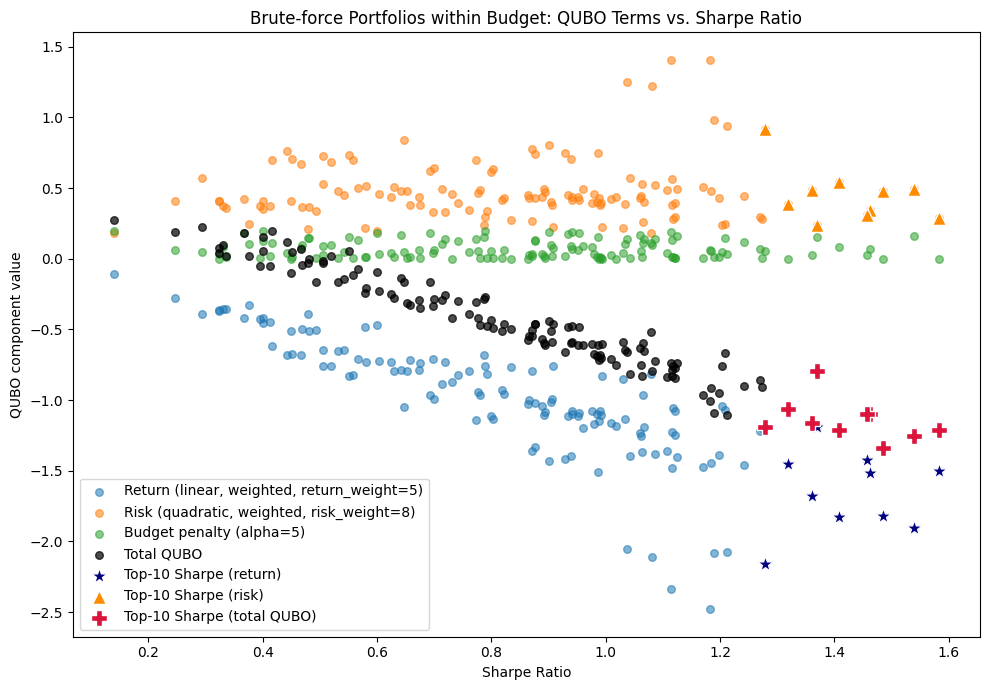

In [5]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np

spent_list = []
return_list = []
risk_list = []
budget_list = []
total_qubo_list = []
sharpe_list = []
bits_list = []

# ---- Loop over all non-empty portfolios ----
for bits in product([0, 1], repeat=num_assets):
    x = np.array(bits)
    if np.sum(x) == 0:
        continue  # skip empty portfolios

    spent = np.sum(prices * x)
    return_contrib = np.dot(-return_weight * returns * prices / budget, x)
    risk_contrib = 0.0
    for i in range(num_assets):
        for j in range(num_assets):
            risk_contrib += risk_weight * covariance[i, j] * prices[i] * prices[j] / budget**2 * x[i] * x[j]
    budget_penalty = alpha * ((spent - budget) / budget) ** 2
    total_qubo = return_contrib + risk_contrib + budget_penalty

    # Compute Sharpe ratio
    sel_prices = prices[x == 1]
    sel_returns = returns[x == 1]
    sel_indices = np.where(x == 1)[0]
    w = sel_prices / np.sum(sel_prices) if np.sum(sel_prices) > 0 else np.zeros_like(sel_prices)
    cov_selected = covariance[np.ix_(sel_indices, sel_indices)]
    port_return = np.sum(w * sel_returns)
    port_vol = np.sqrt(w.T @ cov_selected @ w) if len(sel_indices) > 0 else 0
    sharpe = port_return / port_vol if port_vol > 0 else 0

    spent_list.append(spent)
    return_list.append(return_contrib)
    risk_list.append(risk_contrib)
    budget_list.append(budget_penalty)
    total_qubo_list.append(total_qubo)
    sharpe_list.append(sharpe)
    bits_list.append(bits)

# Convert lists to arrays
spent_arr      = np.array(spent_list)
return_arr     = np.array(return_list)
risk_arr       = np.array(risk_list)
budget_arr     = np.array(budget_list)
total_qubo_arr = np.array(total_qubo_list)
sharpe_arr     = np.array(sharpe_list)

# ---- Filter for portfolios within budget band ----
mask_budget = (spent_arr >= band_low) & (spent_arr <= band_high)

sharpe_in    = sharpe_arr[mask_budget]
return_in    = return_arr[mask_budget]
risk_in      = risk_arr[mask_budget]
budget_in    = budget_arr[mask_budget]
total_qubo_in = total_qubo_arr[mask_budget]

# --- Helper: get indices of top-10 Sharpe for each component (within budget band) ---
def top_sharpe_idxs(component_arr, sharpe_arr, top_n=10):
    idxs = np.argsort(sharpe_arr)[-2*top_n:][::-1]  # get more in case of ties
    used = set()
    result = []
    for idx in idxs:
        val = component_arr[idx]
        if val not in used:
            used.add(val)
            result.append(idx)
        if len(result) >= top_n:
            break
    return np.array(result)

# These indices are *relative* to the filtered arrays (within budget)
top_risk_idx   = top_sharpe_idxs(risk_in, sharpe_in)
top_return_idx = top_sharpe_idxs(return_in, sharpe_in)
top_budget_idx = top_sharpe_idxs(budget_in, sharpe_in)
top_total_idx  = top_sharpe_idxs(total_qubo_in, sharpe_in)

# --- Plot: QUBO components vs. Sharpe ratio, within budget band ---
plt.figure(figsize=(10,7))

plt.scatter(sharpe_in, return_in, s=30, color='tab:blue', alpha=0.55,
            label=f'Return (linear, weighted, return_weight={return_weight})')
plt.scatter(sharpe_in, risk_in, s=30, color='tab:orange', alpha=0.55,
            label=f'Risk (quadratic, weighted, risk_weight={risk_weight})')
plt.scatter(sharpe_in, budget_in, s=30, color='tab:green', alpha=0.55,
            label=f'Budget penalty (alpha={alpha})')
plt.scatter(sharpe_in, total_qubo_in, s=30, color='k', alpha=0.7, label='Total QUBO')

# Highlight top-10 Sharpe portfolios in each component
plt.scatter(sharpe_in[top_return_idx], return_in[top_return_idx], marker='*', s=150, color='navy', edgecolor='white', label='Top-10 Sharpe (return)')
plt.scatter(sharpe_in[top_risk_idx], risk_in[top_risk_idx], marker='^', s=100, color='darkorange', edgecolor='white', label='Top-10 Sharpe (risk)')
plt.scatter(sharpe_in[top_total_idx], total_qubo_in[top_total_idx], marker='P', s=120, color='crimson', edgecolor='white', label='Top-10 Sharpe (total QUBO)')

plt.xlabel('Sharpe Ratio')
plt.ylabel('QUBO component value')
plt.title('Brute-force Portfolios within Budget: QUBO Terms vs. Sharpe Ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()




#**3D Plot: Qubo value vs budget and sharpe score**

In [6]:

import plotly.graph_objs as go
import numpy as np

# --- Prepare QAOA results grouped by budget band ---
qaoa_in_vols, qaoa_in_rets, qaoa_in_sharpes, qaoa_in_bits = [], [], [], []
qaoa_out_vols, qaoa_out_rets, qaoa_out_sharpes, qaoa_out_bits = [], [], [], []

for bits, freq in counts.items():
    res = eval_portfolio(bits)
    if res is not None:
        port_return, port_vol, sharpe, cost = res
        if band_low <= cost <= band_high:
            qaoa_in_vols.append(port_vol)
            qaoa_in_rets.append(port_return)
            qaoa_in_sharpes.append(sharpe)
            qaoa_in_bits.append(bits)
        else:
            qaoa_out_vols.append(port_vol)
            qaoa_out_rets.append(port_return)
            qaoa_out_sharpes.append(sharpe)
            qaoa_out_bits.append(bits)

# --- Compute "spent" and QUBO values for QAOA ---
qaoa_in_spent = []
qaoa_in_qubo = []
for bits in qaoa_in_bits:
    x = np.array([int(b) for b in bits])
    qaoa_in_spent.append(np.sum(prices * x))
    qaoa_in_qubo.append(qubo_value(x, Q, c))

qaoa_out_spent = []
qaoa_out_qubo = []
for bits in qaoa_out_bits:
    x = np.array([int(b) for b in bits])
    qaoa_out_spent.append(np.sum(prices * x))
    qaoa_out_qubo.append(qubo_value(x, Q, c))

# --- Brute-force portfolios: precomputed (from earlier brute-force block) ---

from itertools import product
all_bf_spent = []
all_bf_sharpes = []
all_bf_qubo = []

for bits in product([0, 1], repeat=num_assets):
    x = np.array(bits)
    if np.sum(x) == 0: continue  # skip empty
    spent = np.sum(prices * x)
    sel_indices = np.where(x == 1)[0]
    w = prices[x == 1] / np.sum(prices[x == 1])
    cov_selected = covariance[np.ix_(sel_indices, sel_indices)]
    port_return = np.sum(w * returns[x == 1])
    port_vol = np.sqrt(w.T @ cov_selected @ w)
    sharpe = port_return / port_vol if port_vol > 0 else 0
    qval = qubo_value(x, Q, c)
    all_bf_spent.append(spent)
    all_bf_sharpes.append(sharpe)
    all_bf_qubo.append(qval)

# --- Prepare Plotly traces ---

# Brute-force: light blue (constant color)
trace_bf = go.Scatter3d(
    x=all_bf_spent,
    y=all_bf_sharpes,
    z=all_bf_qubo,
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(0, 153, 255, 0.19)',  # light blue
        opacity=0.75,
    ),
    name='Brute-force (all)'
)

# QAOA within budget: colored by Sharpe
trace_qaoa_in = go.Scatter3d(
    x=qaoa_in_spent,
    y=qaoa_in_sharpes,
    z=qaoa_in_qubo,
    mode='markers',
    marker=dict(
        size=9,
        color=qaoa_in_sharpes,
        colorscale='Viridis',
        colorbar=dict(title='Sharpe (QAOA in)'),
        opacity=0.85,
    ),
    name='QAOA within budget band',
    text=[f"Spent: {s:.2f}<br>Sharpe: {sh:.2f}<br>QUBO: {q:.2f}"
          for s, sh, q in zip(qaoa_in_spent, qaoa_in_sharpes, qaoa_in_qubo)]
)

# QAOA out-of-budget: constant color (pink)
trace_qaoa_out = go.Scatter3d(
    x=qaoa_out_spent,
    y=qaoa_out_sharpes,
    z=qaoa_out_qubo,
    mode='markers',
    marker=dict(
        size=8,
        color='rgba(255, 0, 0, 0.5)',
        opacity=0.7,
    ),
    name='QAOA outside budget band',
    text=[f"Spent: {s:.2f}<br>Sharpe: {sh:.2f}<br>QUBO: {q:.2f}"
          for s, sh, q in zip(qaoa_out_spent, qaoa_out_sharpes, qaoa_out_qubo)]
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Total Spent'),
        yaxis=dict(title='Sharpe Ratio'),
        zaxis=dict(title='QUBO Value')
    ),
    title='3D Portfolio Landscape: Brute-force (light blue), QAOA in/out band',
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.01, y=0.99)
)

fig = go.Figure(data=[trace_bf, trace_qaoa_in, trace_qaoa_out], layout=layout)
fig.show()

#**Efficient Frontier Visualization based on Brute Force**

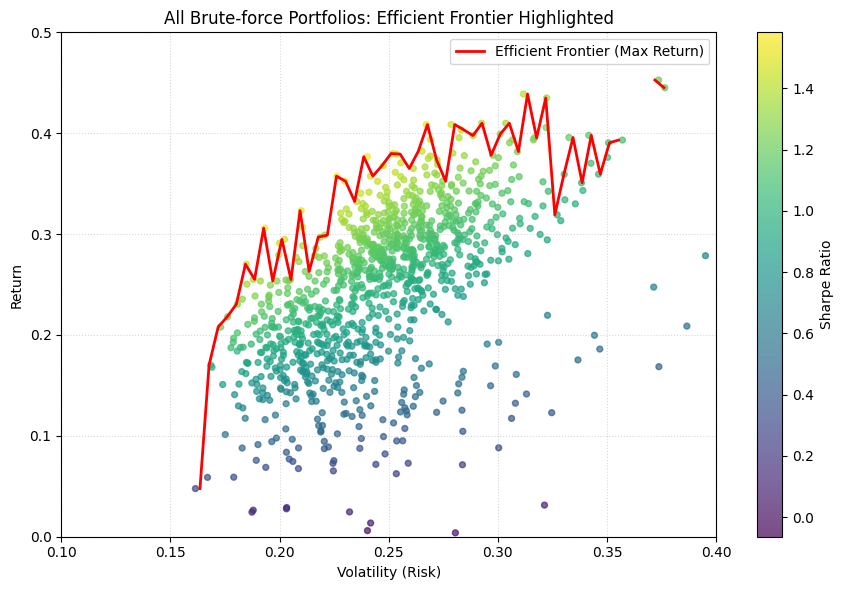

In [7]:
# Find the efficient frontier (max return for each risk bin)
from scipy.stats import binned_statistic

n_bins = 100
bin_means, bin_edges, binnumber = binned_statistic(all_bf_vols, all_bf_rets, statistic='max', bins=n_bins)

# Bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(9, 6))
plt.scatter(all_bf_vols, all_bf_rets, c=all_bf_sharpes, cmap='viridis', s=18, alpha=0.7)
plt.plot(bin_centers, bin_means, color='red', linewidth=2, label='Efficient Frontier (Max Return)')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('All Brute-force Portfolios: Efficient Frontier Highlighted')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(linestyle='dotted', alpha=0.5)
plt.tight_layout()
plt.xlim(0.1, 0.4)
plt.ylim(0.0, 0.5)
plt.show()
